This aim of this code is to introduce you to Python and to simply import a netcdf file in to your python workspace, conduct some basic operations, and plot an image. 

The first step in any python code is to import libraries that you will need. In this case we will import the netcdf library (if you have anaconda you can install with the commands here https://anaconda.org/anaconda/netcdf4/), the numpy library (http://www.numpy.org/) which will help to conduct various operations on the data, and the matplotlib plotting library (http://matplotlib.org/) to generate some images.

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os


Next we will set paths to let python know where our data is stored, and what it is called. If you keep your scripts and files in the same folder, you will not need to set the full path to the data file. However you may want to store things in different places and so it is good practice to be specific. 

In [2]:
input_root    = "."
input_path    = "S3A_OL_2_WRR____20170805T062134_20170805T070550_20170806T113223_2656_020_348______MAR_O_NT_002.SEN3"
file_name_chl = "chl_nn.nc"

Now we will read the file using functions from the netCDF4 library

In [3]:
OLCI_file     =  nc.Dataset(os.path.join(input_root,input_path,file_name_chl), 'r')

To access a variable you can use the following command, where the name of the variable you are interested in, is in the quotes.


In [4]:
#OLCI_file

In [5]:
CHL     = OLCI_file.variables['CHL_NN'][:].data
fillval = OLCI_file.variables['CHL_NN']._FillValue
# check where chl is equal to fill value and set it to 'no data', e.g. nan
CHL[CHL == fillval] = np.nan


You can look at the variables in your workspace in interactive python 
environments (like this, or ipython) by typing 'whos'. This will tell you the name of the variable, it's type and then information on it, such as its size and shape. 

In [6]:
plt.imshow(CHL)

We then need to show the image.

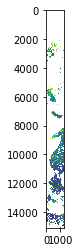

In [7]:
plt.show()

This is not the prettiest plot - Python can do much better - see the example further down, as well as others in the other scripts provided.



Other basic things you may want to do in python include extracting a subsection of the data.
This can be done as below, using the relevant indexes for area of data you wish to use. 

In [8]:
CHL_subset = CHL[10000:13000, :]

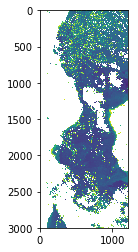

In [9]:
plt.imshow(CHL_subset)
plt.show()

You will notice a few problems with displaying plots like this. Firstly - they don't look very pretty (the colour scheme is not ideal, it is hard to see the coastline, and you can't differentiate the land from cloud), and secondly - the axes don't provide any information on the location (other than within the array) and there is no colour bar. 

To make a better plot we will need to add a few more tools to the libraries/modules we've currently imported. Below are a few lines of code to import basemap (which will help us make a better, map based plot) and a few other tools to tweak how the data is displayed.


In [10]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize

We will also need to load other data to make the plot - the longitude and latitude data associated with each pixel of the chlorophyll data. This data can be found in the geo_coordinates.nc file, within each S3 OLCI L2 folder. We load this in a very similar way to how we loaded the chlorophyll data, just with different file and variable names. The data path remains the same, referring the folder that contains all the netcdf files.


In [11]:
file_name_geo = "geo_coordinates.nc"
# NOTE THAT I HAVE DONE A 'TIE-POINT EXPANSION' HERE TO GET FULL LAT/LON VARIABLES. THIS CAN BE DONE IN SNAP.
GEO_file      = nc.Dataset(os.path.join(input_root,input_path,file_name_geo), 'r')
LAT           = GEO_file.variables['latitude'][:]
LON           = GEO_file.variables['longitude'][:]
LAT_subset    = LAT[10000:13000, :]
LON_subset    = LON[10000:13000, :]
GEO_file.close()

Then we need to initialise the map we will use for plotting. The important things to choose here are:

1. the projection you wish to use (this may depend on your region of interest, particularly if you are looking at polar data, more information about the different projects is available here: https://matplotlib.org/basemap/users/mapsetup.html)
2. The limits of your map (in terms of latitude and longitude, defined by the lower left corner, and upper right corner for each).
3. The resolution of the map (Can be c (crude), l (low), i (intermediate), h (high), f (full) or None).

See more information about the options for basemap here: https://matplotlib.org/basemap/api/basemap_api.html

(If you don't have basemap installed, you can type "conda install -c anaconda basemap" in your command prompt, with the anaconda distribution).


In [12]:
m = Basemap(projection='gall',llcrnrlat=-89,urcrnrlat=89,llcrnrlon=-179,urcrnrlon=179,resolution='c')


We can then start giving various instructions to this m object (our map).

First we must map our latitude and longitude values, to those used in the map projection.


In [13]:
plot_lon, plot_lat = m(LON,LAT)

In [14]:
plt.figure(figsize=(17, 10), dpi=300)
f1=m.pcolormesh(plot_lon,plot_lat,np.ma.masked_invalid(CHL), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)

/Users/benloveday/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/benloveday/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


In [15]:
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='grey')
parallels = np.arange(-100,100,20)
m.drawparallels(parallels,labels=[False,True,True,False], fontsize=20)
meridians = np.arange(-180,180,30)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=20)
cbar = m.colorbar(f1,"bottom",size="5%",pad="7%",ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [Chl a] mg m$^{-3}$', fontsize =20)

/Users/benloveday/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


Now you must show the plot (this may take some time to plot!)

In [16]:
#plt.show()

You can also save the figure using the code below (this will save in the folder where you are running the code, if you want to save elsewhere you need to specify the path).


In [17]:
lonmin=np.nanmin(LON_subset)
lonmax=np.nanmax(LON_subset)
latmin=np.nanmin(LAT_subset)
latmax=np.nanmax(LAT_subset)

m = Basemap(projection='gall',llcrnrlat=latmin,urcrnrlat=latmax,llcrnrlon=lonmin,urcrnrlon=lonmax,resolution='h')


In [18]:

plot_lon, plot_lat = m(LON_subset,LAT_subset)

In [19]:
plt.figure(figsize=(15, 15), dpi=150)
f1=m.pcolormesh(plot_lon,plot_lat,np.ma.masked_invalid(CHL_subset), shading='flat', vmin=np.log10(0.01), vmax=np.log10(50), cmap=plt.cm.viridis)
        

In [20]:
m.drawmapboundary(fill_color='0.9')
m.drawcoastlines()
m.fillcontinents(color='grey',lake_color='grey')
parallels = np.arange(-100,100,20)
m.drawparallels(parallels,labels=[False,True,True,False], fontsize=20)
meridians = np.arange(-180,180,30)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=20)
cbar = m.colorbar(f1,"bottom",size="5%",pad="7%",ticks=[np.log10(0.01), np.log10(0.1),np.log10(0.5), np.log10(1),np.log10(3),np.log10(10),np.log10(50)]) 
cbar.ax.set_xticklabels(['0.01','0.1','0.5','1','3','10','50'], fontsize=20) 
cbar.set_label('Chlorophyll, mg m$^{-3}$', fontsize=20)
plt.title('OLCI [Chl a] mg m$^{-3}$', fontsize =20)

In [21]:
#plt.show()

In [22]:
plt.savefig('OLCI_CHL.png', bbox_inches='tight')